In [17]:
import cv2
import numpy as np
import os

# Set the directory paths for the thermal and visible images
thermal_dir = '/content/4a'
visible_dir = '/content/4b'

# Set the output directory for the hybrid images
output_dir = 'output_hybrid'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all the files in the thermal directory
for filename in os.listdir(thermal_dir):
    if filename.endswith('.bmp') and int(filename.split('_')[-1][:-4]) % 2 == 1:

        # Load the thermal and visible images
        thermal_img = cv2.imread(os.path.join(thermal_dir, filename))
        visible_filename = 'img_' + str(int(filename.split('_')[-1][:-4])-1).zfill(5) + '.bmp'
        visible_img = cv2.imread(os.path.join(visible_dir, visible_filename))


        # Convert the thermal image to grayscale
        thermal_gray = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

        # Resize the thermal image to match the size of the visible image
        thermal_resized = cv2.resize(thermal_gray, (visible_img.shape[1], visible_img.shape[0]))

        # Normalize the pixel values of the thermal image to [0, 255]
        thermal_norm = cv2.normalize(thermal_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

        # Apply a color map to the thermal image
        thermal_color = cv2.applyColorMap(thermal_norm, cv2.COLORMAP_JET)

        # Multi-Scale Fusion
        # Create a Gaussian pyramid for the visible and thermal images
        visible_gaussian_pyramid = [visible_img.copy()]
        thermal_gaussian_pyramid = [thermal_color.copy()]

        for i in range(3):
            visible_gaussian_pyramid.append(cv2.pyrDown(visible_gaussian_pyramid[-1]))
            thermal_gaussian_pyramid.append(cv2.pyrDown(thermal_gaussian_pyramid[-1]))

        # Create a Laplacian pyramid for the visible and thermal images
        visible_laplacian_pyramid = [visible_gaussian_pyramid[-1].copy()]
        thermal_laplacian_pyramid = [thermal_gaussian_pyramid[-1].copy()]

        for i in range(3, 0, -1):
            visible_gaussian_expanded = cv2.pyrUp(visible_gaussian_pyramid[i])
            thermal_gaussian_expanded = cv2.pyrUp(thermal_gaussian_pyramid[i])
            visible_laplacian = cv2.subtract(visible_gaussian_pyramid[i-1], visible_gaussian_expanded)
            thermal_laplacian = cv2.subtract(thermal_gaussian_pyramid[i-1], thermal_gaussian_expanded)
            visible_laplacian_pyramid.append(visible_laplacian)
            thermal_laplacian_pyramid.append(thermal_laplacian)

        # Combine the Laplacian pyramids with different weights
        combined_laplacian_pyramid = []
        for visible_laplacian, thermal_laplacian in zip(visible_laplacian_pyramid, thermal_laplacian_pyramid):
            h, w, c = visible_laplacian.shape
            combined_laplacian = np.zeros((h, w, c), dtype=np.uint8)
            for i in range(c):
                combined_laplacian[:,:,i] = cv2.addWeighted(visible_laplacian[:,:,i], 0.7, thermal_laplacian[:,:,i], 0.3, 0.0)
            combined_laplacian_pyramid.append(combined_laplacian)
        
        # Reconstruct the hybrid image from the combined Laplacian pyramid
        hybrid_img = combined_laplacian_pyramid[0]
        for i in range(1, 4):
            hybrid_expanded = cv2.pyrUp(hybrid_img)
            hybrid_img = cv2.add(combined_laplacian_pyramid[i], hybrid_expanded)

        # Save the hybrid image to the output directory
        cv2.imwrite(os.path.join(output_dir, filename), hybrid_img)

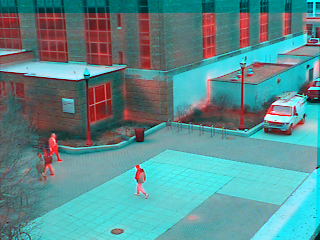

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the visible and thermal images
visible = cv2.imread('/content/img_00000.bmp')
thermal = cv2.imread('/content/img_00001.bmp')

# Resize the thermal image to have the same shape as the visible image
thermal = cv2.resize(thermal, visible.shape[:2][::-1])

# Normalize the pixel values of the thermal image to be between 0 and 255
thermal = cv2.normalize(thermal, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Create a new 3-channel image and fill it with zeros
fused = np.zeros_like(visible)

# Copy the normalized thermal image into the red channel of the fused image
fused[:,:,2] = thermal[:,:,0]

# Copy the visible image into the blue and green channels of the fused image
fused[:,:,0:2] = visible[:,:,0:2]

# Display the fused image
cv2_imshow(fused)

In [ ]:
import cv2
import numpy as np
import os

# Path to the input folders for visible and thermal images
thermal_folder = '/content/drive/MyDrive/4a_for_fusion'
visible_folder = '/content/drive/MyDrive/4b'

# Path to the output folder for fused images
output_folder = '/content/fused_images'

# Loop through the thermal images and fuse them with their corresponding visible images
for i, filename in enumerate(os.listdir(thermal_folder)):
    # Check if the file is a thermal image (odd numbered)
    if i % 2 == 1 and filename.endswith('.bmp'):
        # Load the thermal and visible images
        thermal_path = os.path.join(thermal_folder, filename)
        visible_path = os.path.join(visible_folder, 'img_{:05d}.bmp'.format(i-1))
        thermal = cv2.imread(thermal_path)
        visible = cv2.imread(visible_path)

        # Resize the thermal image to have the same shape as the visible image
        thermal = cv2.resize(thermal, visible.shape[:2][::-1])

        # Normalize the pixel values of the thermal image to be between 0 and 255
        thermal = cv2.normalize(thermal, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Create a new 3-channel image and fill it with zeros
        fused = np.zeros_like(visible)

        # Copy the normalized thermal image into the red channel of the fused image
        fused[:,:,2] = thermal[:,:,0]

        # Copy the visible image into the blue and green channels of the fused image
        fused[:,:,0:2] = visible[:,:,0:2]

        # Save the fused image to the output folder with the same filename as the thermal image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, fused)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def create_fusion_autoencoder(thermal_input_shape, visible_input_shape):
    # Encoder
    thermal_input = Input(shape=thermal_input_shape, name='thermal_input')
    thermal_stream = Conv2D(32, (3, 3), activation='relu', padding='same')(thermal_input)
    thermal_stream = MaxPooling2D(pool_size=(2, 2), padding='same')(thermal_stream)

    visible_input = Input(shape=visible_input_shape, name='visible_input')
    visible_stream = Conv2D(32, (3, 3), activation='relu', padding='same')(visible_input)
    visible_stream = MaxPooling2D(pool_size=(2, 2), padding='same')(visible_stream)

    fused_features = concatenate([thermal_stream, visible_stream])

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(fused_features)
    x = UpSampling2D(size=(2, 2))(x)

    fused_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='fused_output')(x)

    # Create the model
    model = Model(inputs=[thermal_input, visible_input], outputs=[fused_output])

    return model

#-------------------------


import cv2
import glob
import numpy as np

def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.asarray(images)


visible_image_dir = "/content/drive/MyDrive/4b/"
thermal_image_dir = "/content/drive/MyDrive/4a_for_fusion/"

num_images = 30  # Adjust this value to the total number of image pairs in your dataset

visible_image_paths = [visible_image_dir + "img_{:05d}.bmp".format(i) for i in range(0, num_images * 2, 2)]
thermal_image_paths = [thermal_image_dir + "img_{:05d}.bmp".format(i) for i in range(1, num_images * 2, 2)]

print(thermal_image_paths)
print(visible_image_paths)

X_thermal = load_images(thermal_image_paths)
X_visible = load_images(visible_image_paths)


thermal_input_shape = X_thermal.shape[1:]  # Get dimensions and channels of the loaded thermal images
visible_input_shape = X_visible.shape[1:]  # Get dimensions and channels of the loaded visible images


#--------------------------------------


model = create_fusion_autoencoder(thermal_input_shape, visible_input_shape)
model.compile(optimizer='adam', loss=['mse'])

epochs = 200
batch_size = 64
model.fit([X_thermal, X_visible], [X_visible], batch_size=batch_size, epochs=epochs)

['/content/drive/MyDrive/4a_for_fusion/img_00001.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00003.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00005.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00007.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00009.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00011.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00013.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00015.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00017.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00019.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00021.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00023.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00025.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00027.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00029.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00031.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00033.bmp', '/content/drive/MyDrive/4a_for_fusion/img_00035.bmp', '/content/drive/MyDrive/4a_

In [ ]:
# Choose a pair of thermal and visible images from your dataset
thermal_image = X_thermal[0]
visible_image = X_visible[0]

# Expand the dimensions to match the autoencoder input shape
thermal_input = np.expand_dims(thermal_image, axis=0)
visible_input = np.expand_dims(visible_image, axis=0)

# Generate the fused image using the trained autoencoder
fused_image = model.predict([thermal_input, visible_input])

# Remove the batch dimension from the fused image
fused_image = np.squeeze(fused_image, axis=0)

1/1 [==============================] - 0s 73ms/step


In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


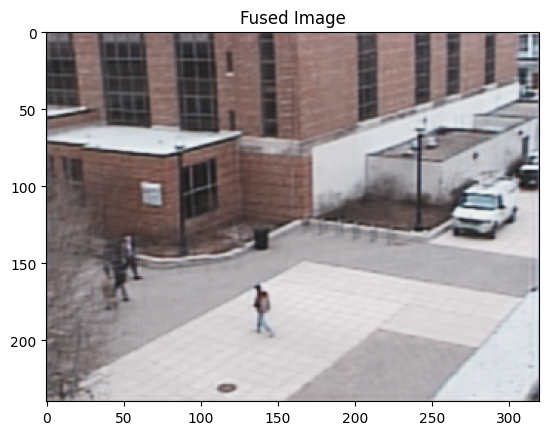

In [ ]:
import matplotlib.pyplot as plt

# Display the fused image
plt.imshow(fused_image)
plt.title("Fused Image")
plt.show()

In [ ]:
plt.imsave("fused_image.png", fused_image)

In [ ]:
import os

def process_and_save_images(model, X_thermal, X_visible, output_folder):
    for i in range(len(X_thermal)):
        thermal_input = np.expand_dims(X_thermal[i], axis=0)
        visible_input = np.expand_dims(X_visible[i], axis=0)

        fused_image = model.predict([thermal_input, visible_input])
        fused_image = np.squeeze(fused_image, axis=0)

        output_path = os.path.join(output_folder, f"fused_image_{i:05d}.png")
        plt.imsave(output_path, fused_image)

output_folder = "/content/fused_images"
process_and_save_images(model, X_thermal, X_visible, output_folder)

1/1 [==============================] - 0s 21ms/step
